In [1]:
# pip install yfinance transformers torch

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
# from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [4]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import yfinance as yf

In [5]:
# Read data from Yahoo Finance
def read_data(tickers, start_date, end_date):
    df = yf.download(tickers=tickers, start=start_date, end=end_date, progress=True)
    print(f"\n shape: {df.shape}\n\n cols: \n{df.columns}\n {df.head(10)}")
    return df

tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG'] 
# AAPL	BA	T	MGM		IBM	TSLA
start_date = '2010-01-01'
end_date = '2025-01-01'
df_prices = read_data(tickers, start_date, end_date)

# Restructure and compute target columns
df = df_prices['Open'].stack().reset_index()
df.columns = ['Date', 'Ticker', 'Open']
df['Close'] = df_prices['Close'].stack().values

# Add other features
for col in ['High', 'Low', 'Volume']:
    df[col] = df_prices[col].stack().values

df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)
df['target_next_close'] = df.groupby('Ticker')['Close'].shift(-1)

# Drop rows with missing target
df = df.dropna(subset=['target_next_close'])

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


 shape: (3774, 20)

 cols: 
MultiIndex([( 'Close', 'AAPL'),
            ( 'Close', 'AMZN'),
            ( 'Close', 'GOOG'),
            ( 'Close', 'MSFT'),
            (  'High', 'AAPL'),
            (  'High', 'AMZN'),
            (  'High', 'GOOG'),
            (  'High', 'MSFT'),
            (   'Low', 'AAPL'),
            (   'Low', 'AMZN'),
            (   'Low', 'GOOG'),
            (   'Low', 'MSFT'),
            (  'Open', 'AAPL'),
            (  'Open', 'AMZN'),
            (  'Open', 'GOOG'),
            (  'Open', 'MSFT'),
            ('Volume', 'AAPL'),
            ('Volume', 'AMZN'),
            ('Volume', 'GOOG'),
            ('Volume', 'MSFT')],
           names=['Price', 'Ticker'])
 Price          Close                                    High          \
Ticker          AAPL    AMZN       GOOG       MSFT      AAPL    AMZN   
Date                                                                   
2010-01-04  6.440331  6.6950  15.536651  23.254047  6.455076  6.8305   
201

In [6]:
# Feature scaling
features = ['Volume', 'High', 'Low', 'Open', 'Close']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [7]:
# Create sequences
window_size = 5

def create_sequences(data, target_col):
    sequences = []
    targets = []
    indices = []
    for i in range(len(data) - window_size):
        seq = data.iloc[i:i+window_size][features].values
        label = data.iloc[i+window_size][target_col]
        sequences.append(seq)
        targets.append(label)
        indices.append(data.index[i + window_size])
    return np.array(sequences), np.array(targets), indices

In [8]:
# Fine-tune per ticker
results = []
for ticker in df['Ticker'].unique():
    group = df[df['Ticker'] == ticker].reset_index(drop=True)

    # Target scaler (fit only on train portion)
    split_point = int(0.9 * len(group))
    scaler_y = MinMaxScaler()
    scaler_y.fit(group.loc[:split_point][['target_next_close']])
    group['target_next_close_scaled'] = scaler_y.transform(group[['target_next_close']])

    # Sequences
    X, y, idx = create_sequences(group, 'target_next_close_scaled')
    split = int(0.8 * len(X))
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]
    test_idx = idx[split:]

    # Dataset class
    class StockDataset(Dataset):
        def __init__(self, X, y):
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.float32)

        def __len__(self):
            return len(self.X)

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    train_loader = DataLoader(StockDataset(X_train, y_train), batch_size=32, shuffle=False)
    test_loader = DataLoader(StockDataset(X_test, y_test), batch_size=32, shuffle=False)

    # LSTM Model
    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size=128, num_layers=3, dropout=0.2):
            super().__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
            self.fc = nn.Linear(hidden_size, 1)

        def forward(self, x):
            out, _ = self.lstm(x)
            out = self.fc(out[:, -1, :])
            return out.squeeze()

    model = LSTMModel(input_size=len(features))
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train
    for epoch in range(20):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"{ticker} - Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

    # Predict
    model.eval()
    y_true_scaled, y_pred_scaled = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            preds = model(X_batch)
            y_true_scaled.extend(y_batch.numpy())
            y_pred_scaled.extend(preds.numpy())

    # Inverse transform
    y_true = scaler_y.inverse_transform(np.array(y_true_scaled).reshape(-1, 1)).flatten()
    y_pred = scaler_y.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1)).flatten()

    # Map to df
    results.append(pd.DataFrame({
        'Date': group.loc[test_idx]['Date'].values,
        'Ticker': ticker,
        'target_next_close': group.loc[test_idx]['target_next_close'].values,
        'pred_target_next_close': y_pred
    }))

# Combine all results
df_results = pd.concat(results)

MinMaxScaler()

LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 1, Loss: 0.0061


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 2, Loss: 0.0256


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 3, Loss: 0.0461


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 4, Loss: 0.0879


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 5, Loss: 0.0470


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 6, Loss: 0.0289


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 7, Loss: 0.0189


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 8, Loss: 0.0214


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 9, Loss: 0.0187


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 10, Loss: 0.0081


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 11, Loss: 0.0095


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 12, Loss: 0.0062


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 13, Loss: 0.0064


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 14, Loss: 0.0034


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 15, Loss: 0.0050


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 16, Loss: 0.0022


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 17, Loss: 0.0037


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 18, Loss: 0.0015


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 19, Loss: 0.0027


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AAPL - Epoch 20, Loss: 0.0013


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MinMaxScaler()

LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 1, Loss: 0.0061


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 2, Loss: 0.0494


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 3, Loss: 0.1009


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 4, Loss: 0.1152


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 5, Loss: 0.0873


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 6, Loss: 0.0260


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 7, Loss: 0.0222


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 8, Loss: 0.0055


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 9, Loss: 0.0042


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 10, Loss: 0.0041


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 11, Loss: 0.0055


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 12, Loss: 0.0049


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 13, Loss: 0.0033


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 14, Loss: 0.0017


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 15, Loss: 0.0009


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 16, Loss: 0.0008


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 17, Loss: 0.0010


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 18, Loss: 0.0013


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 19, Loss: 0.0018


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

AMZN - Epoch 20, Loss: 0.0024


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MinMaxScaler()

LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 1, Loss: 0.0013


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 2, Loss: 0.0309


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 3, Loss: 0.0213


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 4, Loss: 0.0366


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 5, Loss: 0.0788


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 6, Loss: 0.0928


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 7, Loss: 0.0486


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 8, Loss: 0.0171


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 9, Loss: 0.0173


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 10, Loss: 0.0195


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 11, Loss: 0.0112


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 12, Loss: 0.0057


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 13, Loss: 0.0042


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 14, Loss: 0.0043


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 15, Loss: 0.0042


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 16, Loss: 0.0044


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 17, Loss: 0.0054


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 18, Loss: 0.0076


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 19, Loss: 0.0085


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

GOOG - Epoch 20, Loss: 0.0093


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MinMaxScaler()

LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 1, Loss: 0.0011


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 2, Loss: 0.0220


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 3, Loss: 0.0213


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 4, Loss: 0.0872


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 5, Loss: 0.0613


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 6, Loss: 0.0444


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 7, Loss: 0.0272


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 8, Loss: 0.0174


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 9, Loss: 0.0103


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 10, Loss: 0.0182


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 11, Loss: 0.0097


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 12, Loss: 0.0047


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 13, Loss: 0.0107


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 14, Loss: 0.0106


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 15, Loss: 0.0047


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 16, Loss: 0.0099


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 17, Loss: 0.0117


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 18, Loss: 0.0056


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 19, Loss: 0.0073


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

MSFT - Epoch 20, Loss: 0.0097


LSTMModel(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [9]:
# Performance metrics

metrics = []
for ticker, grp in df_results.groupby('Ticker'):
    y_true = grp['target_next_close'].values
    y_pred = grp['pred_target_next_close'].values
    
    mse  = mean_squared_error( y_true, y_pred )
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error( y_true, y_pred )
    mape = np.mean( np.abs((y_true - y_pred) / y_true) ) * 100
    r2   = r2_score( y_true, y_pred )
    
    metrics.append({
      'Ticker':     ticker,
      'MSE':        mse,
      'RMSE':       rmse,
      'MAE':        mae,
      'MAPE (%)':   mape,
      'R²':         r2
    })

# Overall across all tickers
y_all_true = df_results['target_next_close'].values
y_all_pred = df_results['pred_target_next_close'].values
mse_all  = mean_squared_error( y_all_true, y_all_pred )
rmse_all = np.sqrt(mse_all)
mae_all  = mean_absolute_error( y_all_true, y_all_pred )
mape_all = np.mean( np.abs((y_all_true - y_all_pred) / y_all_true) ) * 100
r2_all   = r2_score( y_all_true, y_all_pred )

metrics.append({
  'Ticker':   'Overall',
  'MSE':      mse_all,
  'RMSE':     rmse_all,
  'MAE':      mae_all,
  'MAPE (%)': mape_all,
  'R²':       r2_all
})

perf_df = pd.DataFrame(metrics).set_index('Ticker')
print(perf_df)


                 MSE       RMSE        MAE   MAPE (%)        R²
Ticker                                                         
AAPL      591.816693  24.327283  18.231743   9.276708  0.323167
AMZN     1243.850775  35.268269  30.656917  25.132684 -0.005270
GOOG     1070.099871  32.712381  31.742649  25.460767 -0.399166
MSFT     1712.655861  41.384247  30.867132   8.166017  0.663793
Overall  1154.605800  33.979491  27.874610  17.009044  0.860225


In [10]:
# Metrics
mse = mean_squared_error(df_results['target_next_close'], df_results['pred_target_next_close'])
mae = mean_absolute_error(df_results['target_next_close'], df_results['pred_target_next_close'])
r2 = r2_score(df_results['target_next_close'], df_results['pred_target_next_close'])

print(f"\nOverall Performance:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")


Overall Performance:
MSE: 1154.6058
MAE: 27.8746
R^2 Score: 0.8602


<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted target_next_close (Per-Ticker Fine-Tuning)')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

(array([18993., 19113., 19236., 19358., 19478., 19601., 19723., 19844.,
        19967., 20089.]),
 [Text(18993.0, 0, '2022-01'),
  Text(19113.0, 0, '2022-05'),
  Text(19236.0, 0, '2022-09'),
  Text(19358.0, 0, '2023-01'),
  Text(19478.0, 0, '2023-05'),
  Text(19601.0, 0, '2023-09'),
  Text(19723.0, 0, '2024-01'),
  Text(19844.0, 0, '2024-05'),
  Text(19967.0, 0, '2024-09'),
  Text(20089.0, 0, '2025-01')])

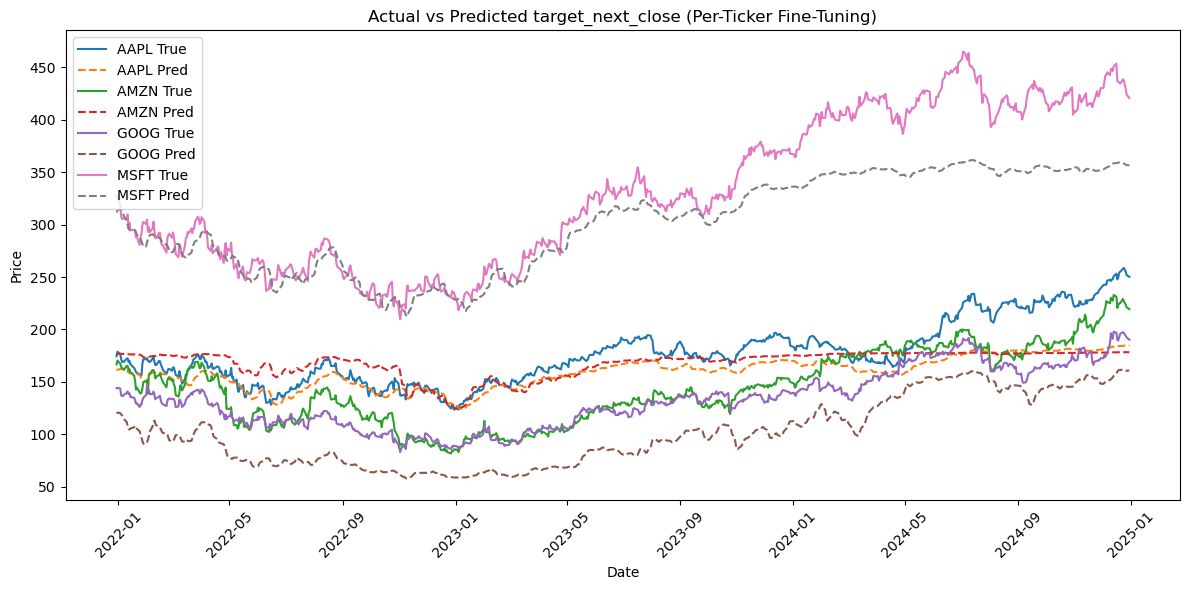

In [11]:
# Plot
plt.figure(figsize=(12, 6))
for ticker in df_results['Ticker'].unique():
    ticker_df = df_results[df_results['Ticker'] == ticker]
    plt.plot(ticker_df['Date'], ticker_df['target_next_close'], label=f'{ticker} True')
    plt.plot(ticker_df['Date'], ticker_df['pred_target_next_close'], '--', label=f'{ticker} Pred')

plt.title("Actual vs Predicted target_next_close (Per-Ticker Fine-Tuning)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted target_next_close for AAPL')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

(array([18993., 19113., 19236., 19358., 19478., 19601., 19723., 19844.,
        19967., 20089.]),
 [Text(18993.0, 0, '2022-01'),
  Text(19113.0, 0, '2022-05'),
  Text(19236.0, 0, '2022-09'),
  Text(19358.0, 0, '2023-01'),
  Text(19478.0, 0, '2023-05'),
  Text(19601.0, 0, '2023-09'),
  Text(19723.0, 0, '2024-01'),
  Text(19844.0, 0, '2024-05'),
  Text(19967.0, 0, '2024-09'),
  Text(20089.0, 0, '2025-01')])

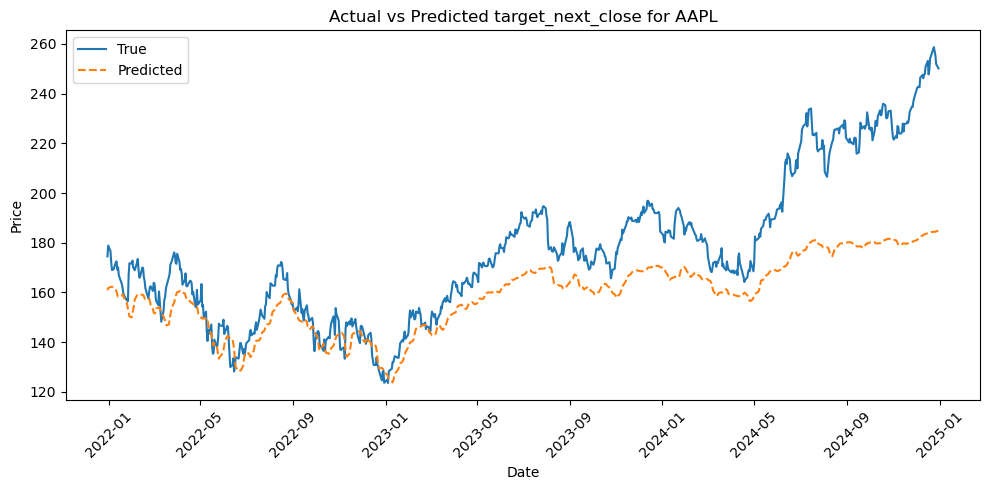

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted target_next_close for AMZN')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

(array([18993., 19113., 19236., 19358., 19478., 19601., 19723., 19844.,
        19967., 20089.]),
 [Text(18993.0, 0, '2022-01'),
  Text(19113.0, 0, '2022-05'),
  Text(19236.0, 0, '2022-09'),
  Text(19358.0, 0, '2023-01'),
  Text(19478.0, 0, '2023-05'),
  Text(19601.0, 0, '2023-09'),
  Text(19723.0, 0, '2024-01'),
  Text(19844.0, 0, '2024-05'),
  Text(19967.0, 0, '2024-09'),
  Text(20089.0, 0, '2025-01')])

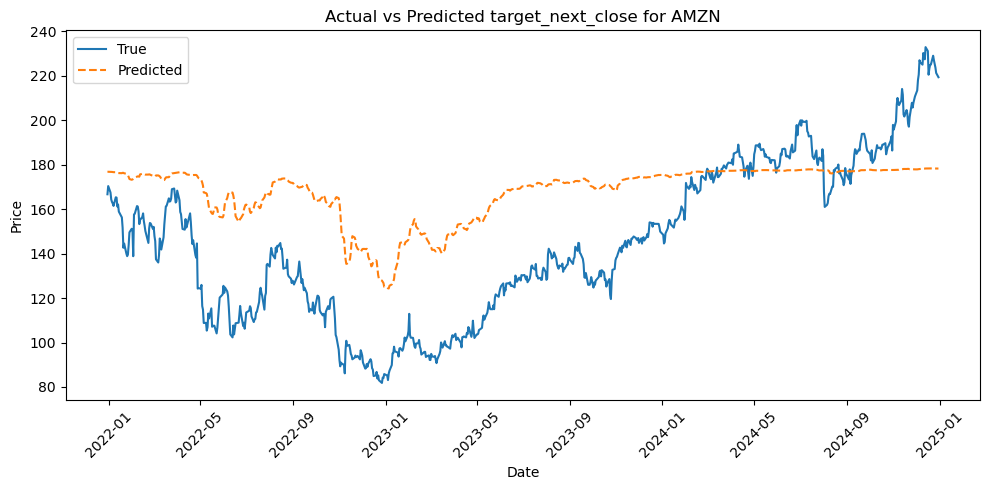

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted target_next_close for GOOG')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

(array([18993., 19113., 19236., 19358., 19478., 19601., 19723., 19844.,
        19967., 20089.]),
 [Text(18993.0, 0, '2022-01'),
  Text(19113.0, 0, '2022-05'),
  Text(19236.0, 0, '2022-09'),
  Text(19358.0, 0, '2023-01'),
  Text(19478.0, 0, '2023-05'),
  Text(19601.0, 0, '2023-09'),
  Text(19723.0, 0, '2024-01'),
  Text(19844.0, 0, '2024-05'),
  Text(19967.0, 0, '2024-09'),
  Text(20089.0, 0, '2025-01')])

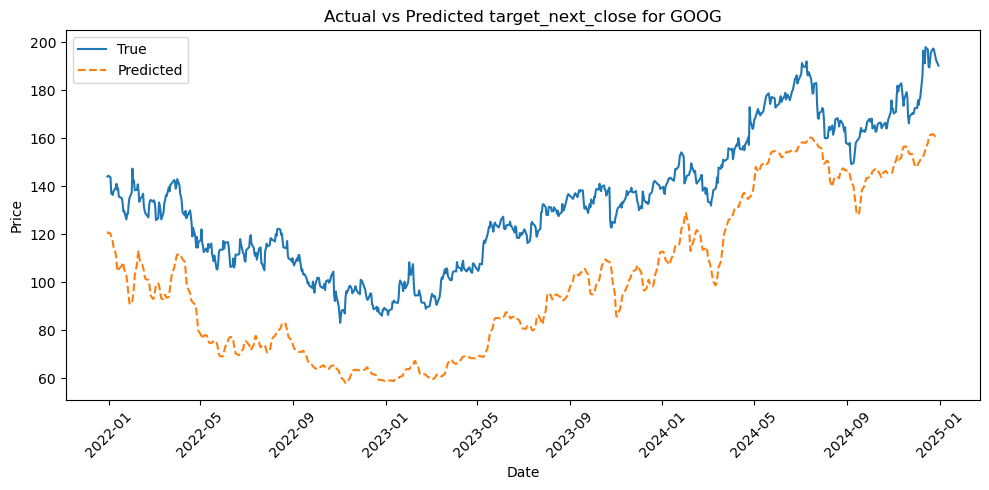

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted target_next_close for MSFT')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

(array([18993., 19113., 19236., 19358., 19478., 19601., 19723., 19844.,
        19967., 20089.]),
 [Text(18993.0, 0, '2022-01'),
  Text(19113.0, 0, '2022-05'),
  Text(19236.0, 0, '2022-09'),
  Text(19358.0, 0, '2023-01'),
  Text(19478.0, 0, '2023-05'),
  Text(19601.0, 0, '2023-09'),
  Text(19723.0, 0, '2024-01'),
  Text(19844.0, 0, '2024-05'),
  Text(19967.0, 0, '2024-09'),
  Text(20089.0, 0, '2025-01')])

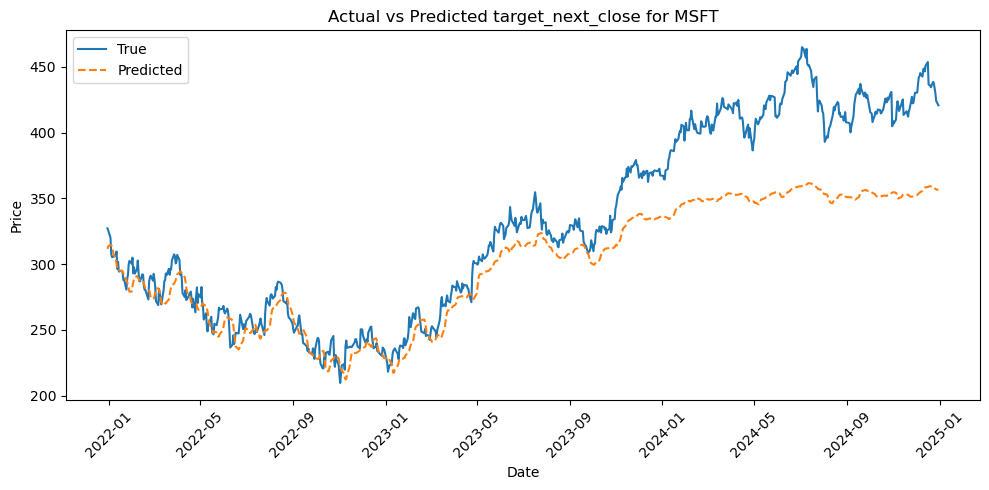

In [12]:
# Individual plots per ticker
for ticker in df_results['Ticker'].unique():
    ticker_df = df_results[df_results['Ticker'] == ticker]
    plt.figure(figsize=(10, 5))
    plt.plot(ticker_df['Date'], ticker_df['target_next_close'], label='True')
    plt.plot(ticker_df['Date'], ticker_df['pred_target_next_close'], '--', label='Predicted')
    plt.title(f"Actual vs Predicted target_next_close for {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()